In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pickle

from glob import glob
import os

### Read nsga logs

In [2]:
total_df = pd.DataFrame(columns=["gen", "nevals", "best", "f", "run"])

popsize = 32
log_folder = "logs_nsga"
files = glob(os.path.join(log_folder, "*.csv"))
for file in files:
    f_type = file.split("-")[1]
    run = file.split("-")[-1].split(".")[0]
    df = pd.read_csv(file)
    df = df[["generation", "dissim", "cog"]]
    df = pd.DataFrame({
                    "gen": df["generation"],
                    "nevals": 1,
                    "best": df["cog"],
                    "dissim": df["dissim"],
                    "f": f_type,
                    "run": run,
                    })
    total_df = pd.concat([total_df, df])
total_df.reset_index(drop=True, inplace=True)
total_df["best"] = total_df["best"].astype(float)

/var/folders/cp/w6zb81516yz3b7dw7m2sgt_80000gn/T/ipykernel_2356/2646814884.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_df = pd.concat([total_df, df])


### Read time

In [3]:
time_data = []

# Time files are saved in the same folder as logs
log_folder = "logs_nsga"
files = glob(os.path.join(log_folder, "*-time.txt"))
for file in files:
    f_type = file.split("-")[1]
    run = file.split("-")[-2]
    with open(file) as f:
        time = f.readline()
    time_data.append([f_type, run, time])

time_df = pd.DataFrame(time_data, columns=["f", "run", "time"])
time_df.time = time_df.time.astype("float")

In [4]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
cmap = matplotlib.colormaps["tab10"]

# Set the colors for each genetic representation
gen_reps = total_df["f"].unique()
color_dict = {mut: cmap(float(i / len(gen_reps))) for i, mut in enumerate(gen_reps)}
color_dict = dict(sorted(color_dict.items()))

In [5]:
gen = max(total_df["gen"])
print(f"Max generation: {gen}")
total_df.head()

Max generation: 50


,gen,nevals,best,f,run,dissim
0,1,1,0.000000e+00,f0,8,17.62500
1,1,1,0.000000e+00,f0,8,15.06250
2,1,1,0.000000e+00,f0,8,17.21875
3,1,1,0.000000e+00,f0,8,16.53125
4,1,1,2.166531e-15,f0,8,18.68750


### Plot best individuals

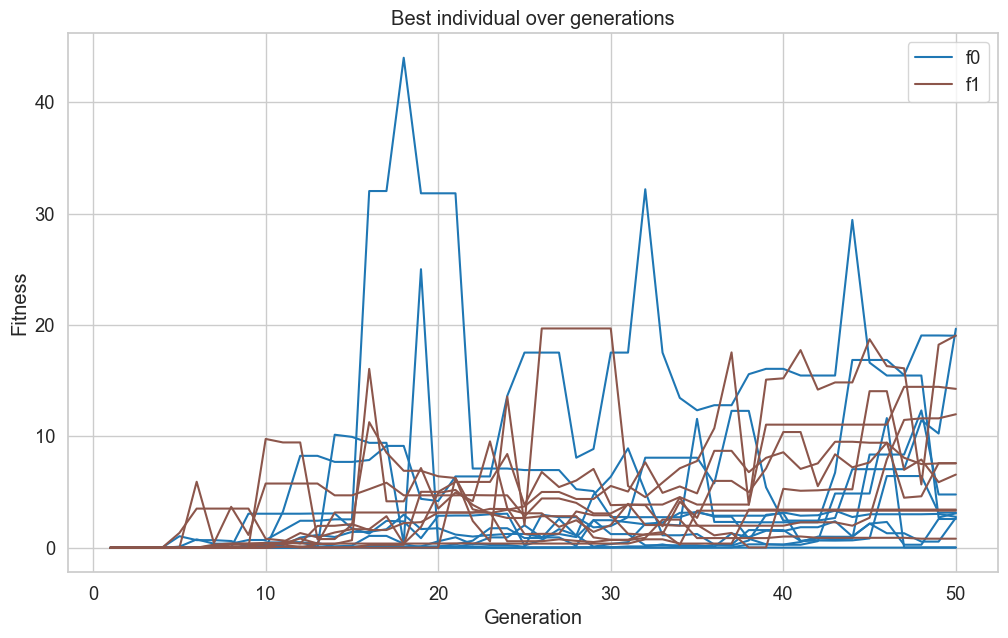

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))

# Group the dataframe by genetic representation
grouped_df = total_df.groupby("f")

# Plot each group as a separate line
for i, (gen_rep, group) in enumerate(grouped_df):
    run_grouped_df = group.groupby("run")
    for j, (run, run_group) in enumerate(run_grouped_df):
        data = run_group.groupby("gen").max()
        ax.plot(
            data.index,
            data["best"],
            label=gen_rep,
            color=color_dict[gen_rep],
        )

# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Add labels and title
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
ax.set_title("Best individual over generations")

# fig.tight_layout()
# Show the plot
plt.show()
fig.savefig(f"best_individual_{gen}.pdf")

### Time and HoF fitness boxplots

/var/folders/cp/w6zb81516yz3b7dw7m2sgt_80000gn/T/ipykernel_2356/3300847531.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(gen_rep_labels)
/var/folders/cp/w6zb81516yz3b7dw7m2sgt_80000gn/T/ipykernel_2356/3300847531.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(


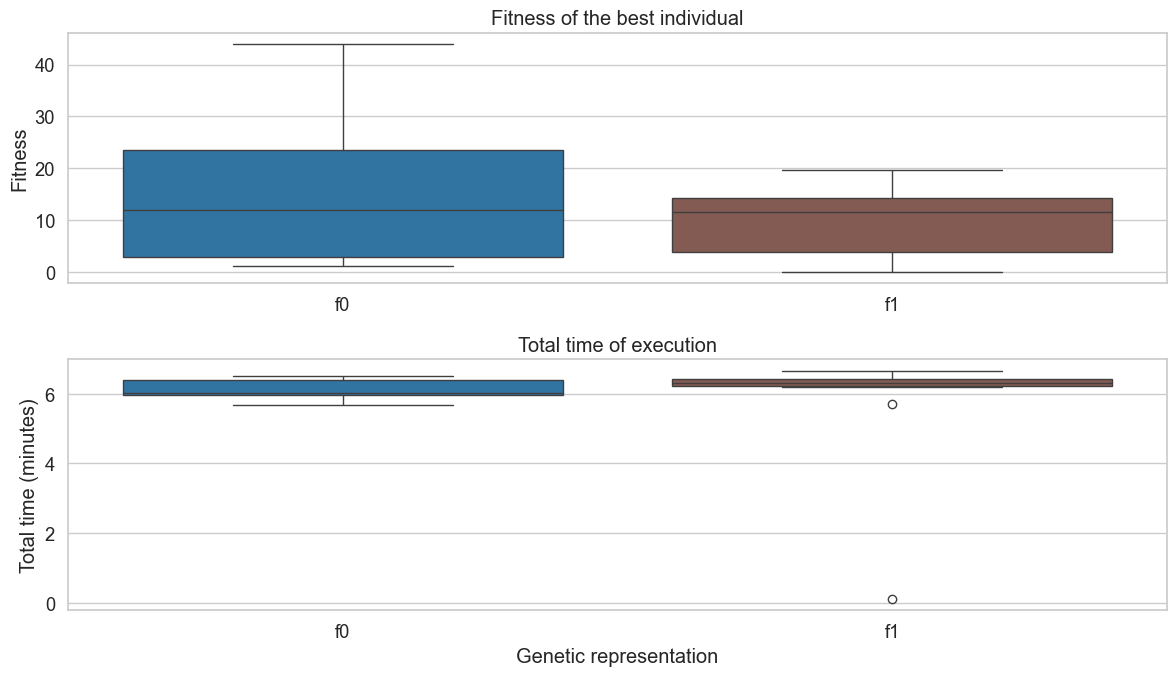

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))

# Group the dataframe by genetic representation
grouped_df = total_df.groupby("f")

gen_rep_data = []
gen_rep_labels = []
for i, (gen_rep, group) in enumerate(grouped_df):
    run_grouped_df = group.groupby("run")
    # Gather the data for each run
    runs_data = []
    for j, (run, run_group) in enumerate(run_grouped_df):
        runs_data.append(run_group["best"].max())
    gen_rep_data.append(runs_data)
    gen_rep_labels.append(gen_rep)
sns.boxplot(gen_rep_data, palette=list(color_dict.values()), ax=ax1)
ax1.set_xticklabels(gen_rep_labels)

time_df["time"] = time_df["time"] / 60
ax2 = sns.boxplot(
    x="f",
    y="time",
    data=time_df,
    order=list(color_dict.keys()),
    palette=list(color_dict.values()),
    ax=ax2,
)

# Add labels and title
ax1.set_ylabel("Fitness")
ax1.set_title("Fitness of the best individual")
ax2.set_xlabel("Genetic representation")
ax2.set_ylabel("Total time (minutes)")
ax2.set_title("Total time of execution")

fig.tight_layout()
# Show the plot
plt.show()
fig.savefig(f"hof_boxplot_fitness_{gen}.pdf")